In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import mplcyberpunk
%matplotlib inline

# plt.style.use('ggplot')
plt.style.use("cyberpunk")

import os
os.getcwd()

'/home/jovyan/work/Capstone_3/Skincare-Recommender'

In [3]:
# Import Custom Modules
from src.helpers import *
from src.final_rec import *

In [4]:
# Import Data
items = pd.read_csv('data/items_final.csv')
users = pd.read_csv('data/user_final.csv')
chemicals = pd.read_csv('data/chemical_effects_final.csv')

# LDA for Ingredient Features

In [5]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
pyLDAvis.enable_notebook()


In [6]:
# Get Ingredients
ingredients = items['ingredients']
# Vectorize Ingredients

# Count Vec
cnt_vec = CountVectorizer(strip_accents='unicode', lowercase=True, token_pattern=r'\b[a-zA-Z]{3,}\b')
doc_term_matrix = cnt_vec.fit_transform(ingredients)
# TFIDF Vec
tfidf_vec = TfidfVectorizer(**cnt_vec.get_params())
doc_term_matrix_tfidf = tfidf_vec.fit_transform(ingredients)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [7]:
n_comp = 5
num_words = 10
# Perform LDA
# TF ONLY
lda_term_freq = LatentDirichletAllocation(n_components=n_comp, random_state=0)
lda_term_freq.fit(doc_term_matrix)
# TFIDF
lda_term_freq_idf = LatentDirichletAllocation(n_components=n_comp, random_state=0)
lda_term_freq_idf.fit(doc_term_matrix_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [8]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_term_freq, cnt_vec, num_words)

Topics found via LDA:

Topic #0:
extract sodium acid oil glycol root alcohol glyceryl palmitoyl polypeptide

Topic #1:
extract oil glycol sodium water leaf centella asiatica acid lecithin

Topic #2:
extract leaf flower peg glycol acid sodium oil stearate fruit

Topic #3:
argan oil hyaluronate stearic fruit alcohol edta dimethicone butylene glycerin

Topic #4:
extract glycol dimethicone sodium root fruit hyaluronate disodium edta butylene


In [9]:
# Visualize LDA
LDA_prepared = pyLDAvis.sklearn.prepare(lda_term_freq, doc_term_matrix_tfidf, cnt_vec)

In [10]:
# Write to File
# pyLDAvis.save_html(LDA_prepared, 'media/previews/lda.html')

# Modeling with Surprise

In [11]:
import surprise
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate 
from surprise.model_selection import train_test_split
from surprise.model_selection import RandomizedSearchCV

from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise.model_selection import cross_validate
from surprise import KNNBaseline
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

## SVD

In [12]:
# Start with SVD
data = users[['user_id', 'item_name', 'star_rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

trainset, testset = train_test_split(data, test_size=.5)

In [13]:
# Train SVD Model
svd = SVD(n_epochs=100)
svd.fit(trainset)

In [14]:
svd_predictions = svd.test(testset)
accuracy.rmse(svd_predictions)
accuracy.mae(svd_predictions)

RMSE: 1.1855
MAE:  0.9244


0.9243577914717265

Predictions look decent, with testing on different test sizes, it was found nearing 0.2 test_split resulted in best RMSE

## SVDpp

In [15]:
svd_pp = SVDpp(n_epochs=100)
svd_pp.fit(trainset)

In [16]:
svdpp_predictions = svd_pp.test(testset)
accuracy.rmse(svdpp_predictions)
accuracy.mae(svdpp_predictions)

RMSE: 1.2019
MAE:  0.9451


0.9450826898432672

# Modeling with LightFM

In [17]:
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k, recall_at_k

In [18]:
# Create Utility Matrix
utility_matrix = create_utility_mat(df=users, user_col='user_id', item_col = 'item_name', rating_col='star_rating')
utility_matrix

item_name,item_1,item_10,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9
user_id,,,,,,,,,,
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
19474,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19475,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19476,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Run Matrix Factorization
n_comp = 30
loss_metric = 'warp' 
k = 15
epoch = 30
n_jobs = 4

# Create Matrix Factorization Model
x = sparse.csr_matrix(utility_matrix.values)

mf_model = LightFM(no_components=n_comp,
                   loss=loss_metric,
                   k=k
)

mf_model.fit(x,
             epochs=epoch, 
             num_threads=n_jobs
)
train_auc = auc_score(mf_model, 
                      x, 
                      num_threads=n_jobs).mean()


print('Collaborative filtering AUC: %s' % train_auc)
print("Train precision: %.4f" % precision_at_k(mf_model, 
                                               x, 
                                               k=k,
                                               num_threads=n_jobs).mean())

Collaborative filtering AUC: 1.0
Train precision: 0.0683


# K Means Clustering of Users

In [40]:
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

In [41]:
# Use CSR Matrix for Sparcity
sparse_ratings = csr_matrix(utility_matrix)
# sparse_ratings = utility_matrix

In [42]:
# Predict 20 clusters
predictions = KMeans(n_clusters=10, algorithm='full').fit_predict(sparse_ratings)

In [43]:
# clustered.group.unique
# utility_matrix

cluster # 7
# of users in cluster: 2918. # of users in plot: 2000


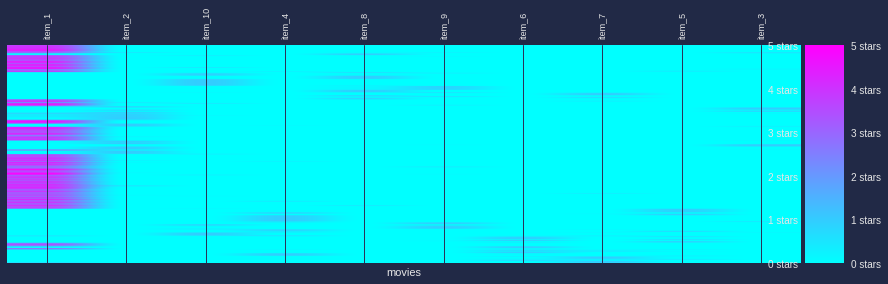

cluster # 1
# of users in cluster: 1863. # of users in plot: 1863


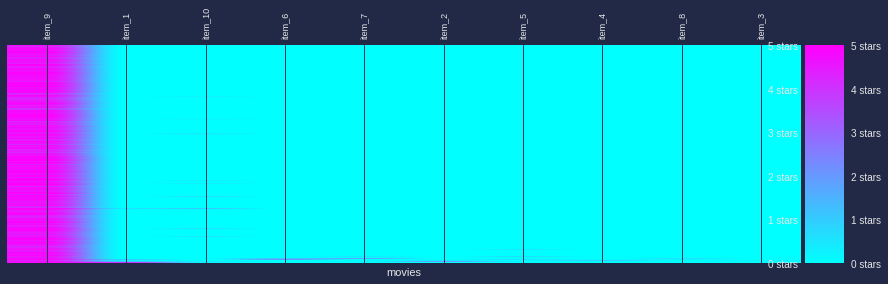

cluster # 5
# of users in cluster: 1877. # of users in plot: 1877


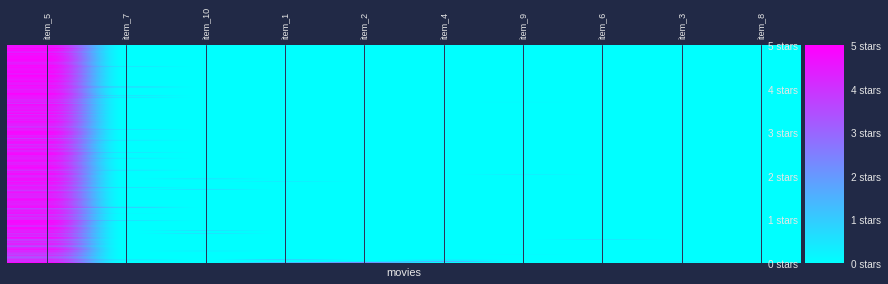

cluster # 6
# of users in cluster: 1822. # of users in plot: 1822


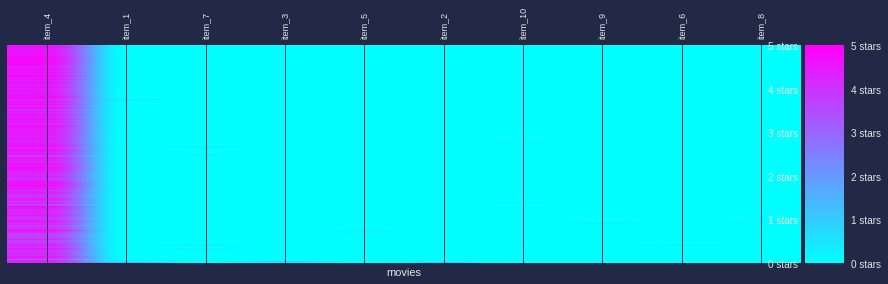

cluster # 4
# of users in cluster: 1862. # of users in plot: 1862


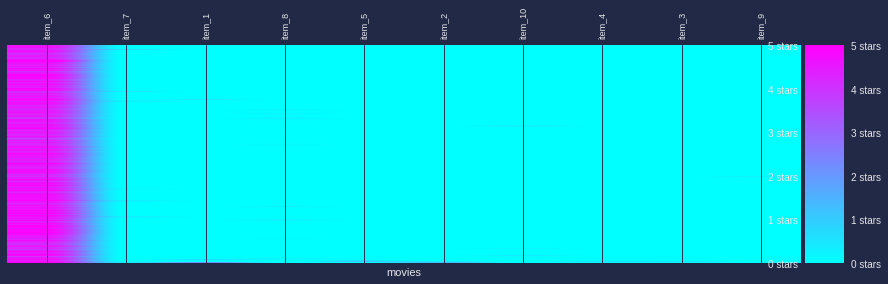

cluster # 8
# of users in cluster: 1796. # of users in plot: 1796


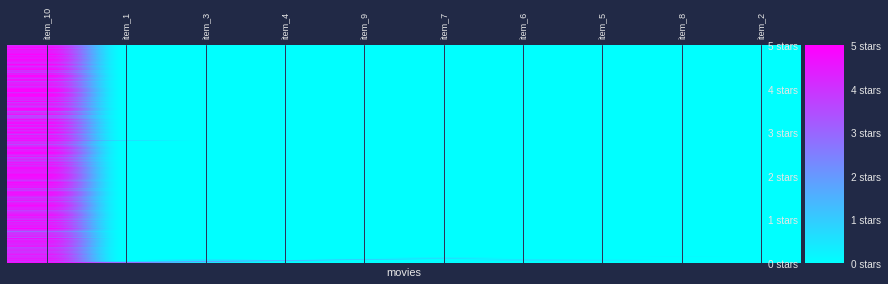

cluster # 9
# of users in cluster: 1725. # of users in plot: 1725


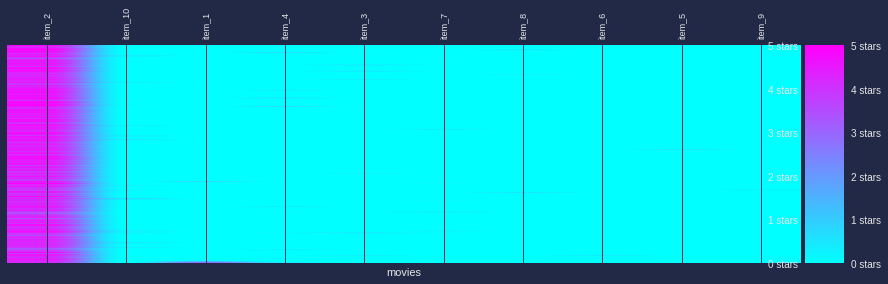

cluster # 2
# of users in cluster: 1894. # of users in plot: 1894


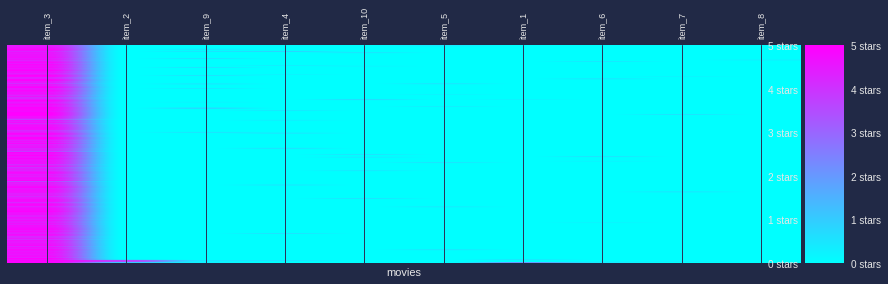

cluster # 3
# of users in cluster: 1851. # of users in plot: 1851


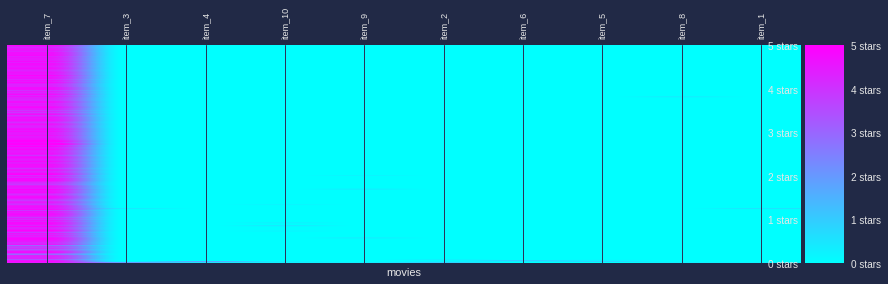

cluster # 0
# of users in cluster: 1871. # of users in plot: 1871


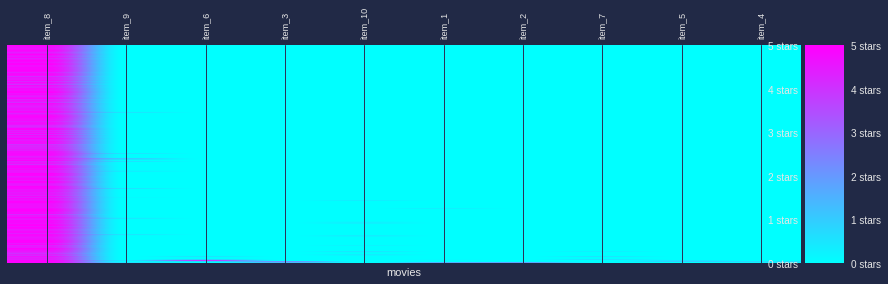

In [44]:
# Plot Heatmap
max_users = 2000
max_items = 10

clustered = pd.concat([utility_matrix.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_clusters(clustered, max_users, max_items)